In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2.0],
    c2 = [0.5, 2.0],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

see one see two 2.0 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c2 = np.max([model.optimizer.C2[1] - ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[0]])
    model.optimizer.c1 = np.min([model.optimizer.C1[0] + ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 10, Accuracy: 0.8888888888888888, Loss: 0.6845644491690176
Checkpoint 20, Accuracy: 0.8765432098765432, Loss: 0.629113373933015
Checkpoint 30, Accuracy: 0.8703703703703703, Loss: 0.6243889420120804
Checkpoint 40, Accuracy: 0.8703703703703703, Loss: 0.6258531499792028
Checkpoint 50, Accuracy: 0.8641975308641975, Loss: 0.6277359856499566
Checkpoint 60, Accuracy: 0.8888888888888888, Loss: 0.5704198766637731
Checkpoint 70, Accuracy: 0.8580246913580247, Loss: 0.48705298812301073
Checkpoint 80, Accuracy: 0.9074074074074074, Loss: 0.4427475399441189
Checkpoint 90, Accuracy: 0.9259259259259259, Loss: 0.3605002650508174
Checkpoint 100, Accuracy: 0.9074074074074074, Loss: 0.2911950217352973
Checkpoint 110, Accuracy: 0.9074074074074074, Loss: 0.2523175698739511
Checkpoint 120, Accuracy: 0.9506172839506173, Loss: 0.2167509573477286
Checkpoint 130, Accuracy: 0.9629629629629629, Loss: 0.20696134920473452
Checkpoint 140, Accuracy: 0.9567901234567902, Loss: 0.17413181728786892
Checkpoint 15

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

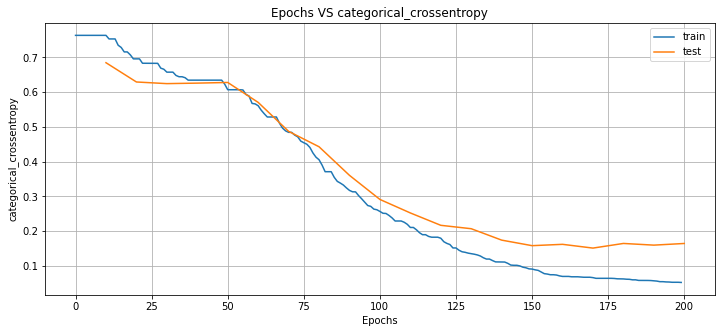

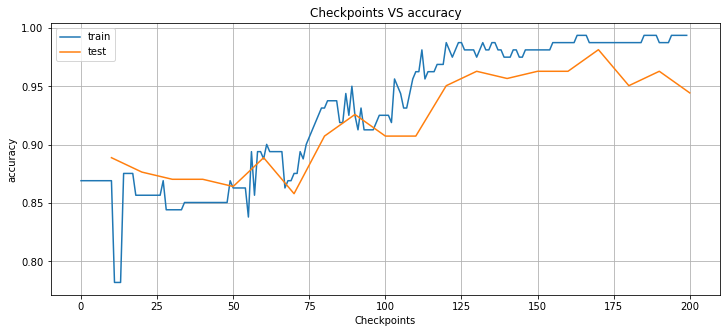

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [9.8591459e-01 6.5069087e-04 1.3434721e-02]
[1. 0. 0.] <-> [0.98825663 0.00128641 0.01045697]
[0. 0. 1.] <-> [9.641099e-02 3.546153e-04 9.032344e-01]
[1. 0. 0.] <-> [9.8919535e-01 3.5810139e-04 1.0446490e-02]
[1. 0. 0.] <-> [9.8316944e-01 2.9785535e-04 1.6532710e-02]
[0. 1. 0.] <-> [0.00918907 0.9897871  0.00102386]
[1. 0. 0.] <-> [0.92616963 0.0606211  0.01320929]
[0. 0. 1.] <-> [8.6710282e-02 1.9593055e-04 9.1309375e-01]
[1. 0. 0.] <-> [0.9894531  0.00372355 0.00682338]
[1. 0. 0.] <-> [9.7394717e-01 3.1293390e-04 2.5739960e-02]
[1. 0. 0.] <-> [0.9492928  0.00205704 0.04865021]
[0. 1. 0.] <-> [0.00923241 0.9897405  0.00102705]
[1. 0. 0.] <-> [9.898717e-01 2.962629e-04 9.832007e-03]
[1. 0. 0.] <-> [0.96208715 0.00133629 0.03657664]
[1. 0. 0.] <-> [0.9888813  0.0035622  0.00755642]
[0. 1. 0.] <-> [0.00918891 0.9897872  0.00102386]
[0. 1. 0.] <-> [0.12106831 0.87535495 0.00357674]
[1. 0. 0.] <-> [9.8631859e-01 5.0178455e-04 1.3179634e-02]
[1. 0. 0.] <-> [0.9870936  0.00313

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8888888888888888, 'mean_square_error': 0.33064346880978973, 'categorical_crossentropy': 0.6845644491690176, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 18, 'tn_hit': 12, 'fn_hit': 0}, 1: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 4}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 14}}, 'checkpoint': 10} 


{'accuracy': 0.8765432098765432, 'mean_square_error': 0.32529868439937637, 'categorical_crossentropy': 0.629113373933015, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 20, 'tn_hit': 10, 'fn_hit': 0}, 1: {'tp_hit': 10, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 6}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 14}}, 'checkpoint': 20} 


{'accuracy': 0.8703703703703703, 'mean_square_error': 0.3481357698998196, 'categorical_crossentropy': 0.6243889420120804, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 21, 'tn_hit': 9, 'fn_hit': 0}, 1: {'tp_hit': 9, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 7}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 94, 'fn_hi

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[ 1.8831952 -2.3050163 -1.6925172 -3.        -3.       ]
 bias: -0.19196897745132446

Neuron 1: weights:
[ 1.4254651  -2.150493   -2.8990273   0.8753511   0.25886437]
 bias: -0.5106078386306763

Neuron 2: weights:
[-2.0619745  2.5114977  2.9561992  3.         1.0523995]
 bias: -0.427850604057312

Neuron 3: weights:
[-0.06676874  3.          0.3832335  -2.240793   -1.5602993 ]
 bias: 2.2723920345306396

$
Layer 2
Neuron 0: weights:
[ 1.2858447   0.29220313 -3.          3.        ]
 bias: -0.33852091431617737

Neuron 1: weights:
[-3. -3.  3.  3.]
 bias: -1.6590276956558228

Neuron 2: weights:
[-1.0440685  3.        -0.4380015 -3.       ]
 bias: 0.905055582523346

$

